In [3]:
from sklearn.datasets import load_breast_cancer, fetch_california_housing, load_iris
import pandas as pd

cancer = load_breast_cancer()
cancer_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
cancer_df['target'] = cancer.target
cancer_df.to_csv('breast_cancer.csv', index=False)

housing = fetch_california_housing()
housing_df = pd.DataFrame(housing.data, columns=housing.feature_names)
housing_df['target'] = housing.target
housing_df.to_csv('california_housing.csv', index=False)

iris = load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['target'] = iris.target
iris_df.to_csv('iris.csv', index=False)

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def calculate_correlation_matrix(dataset_name, df, target_col='target'):    
    features = df.drop(columns=[target_col], errors='ignore')
    
    correlation_matrix = features.corr()
    
    plt.figure(figsize=(15, 12))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=True, 
                fmt=".2f", 
                cmap='coolwarm', 
                center=0,
                square=True,
                cbar_kws={"shrink": .8})
    plt.title(f'Corr Matrix of - {dataset_name}\n', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'correlation_heatmap_{dataset_name.replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return correlation_matrix, features

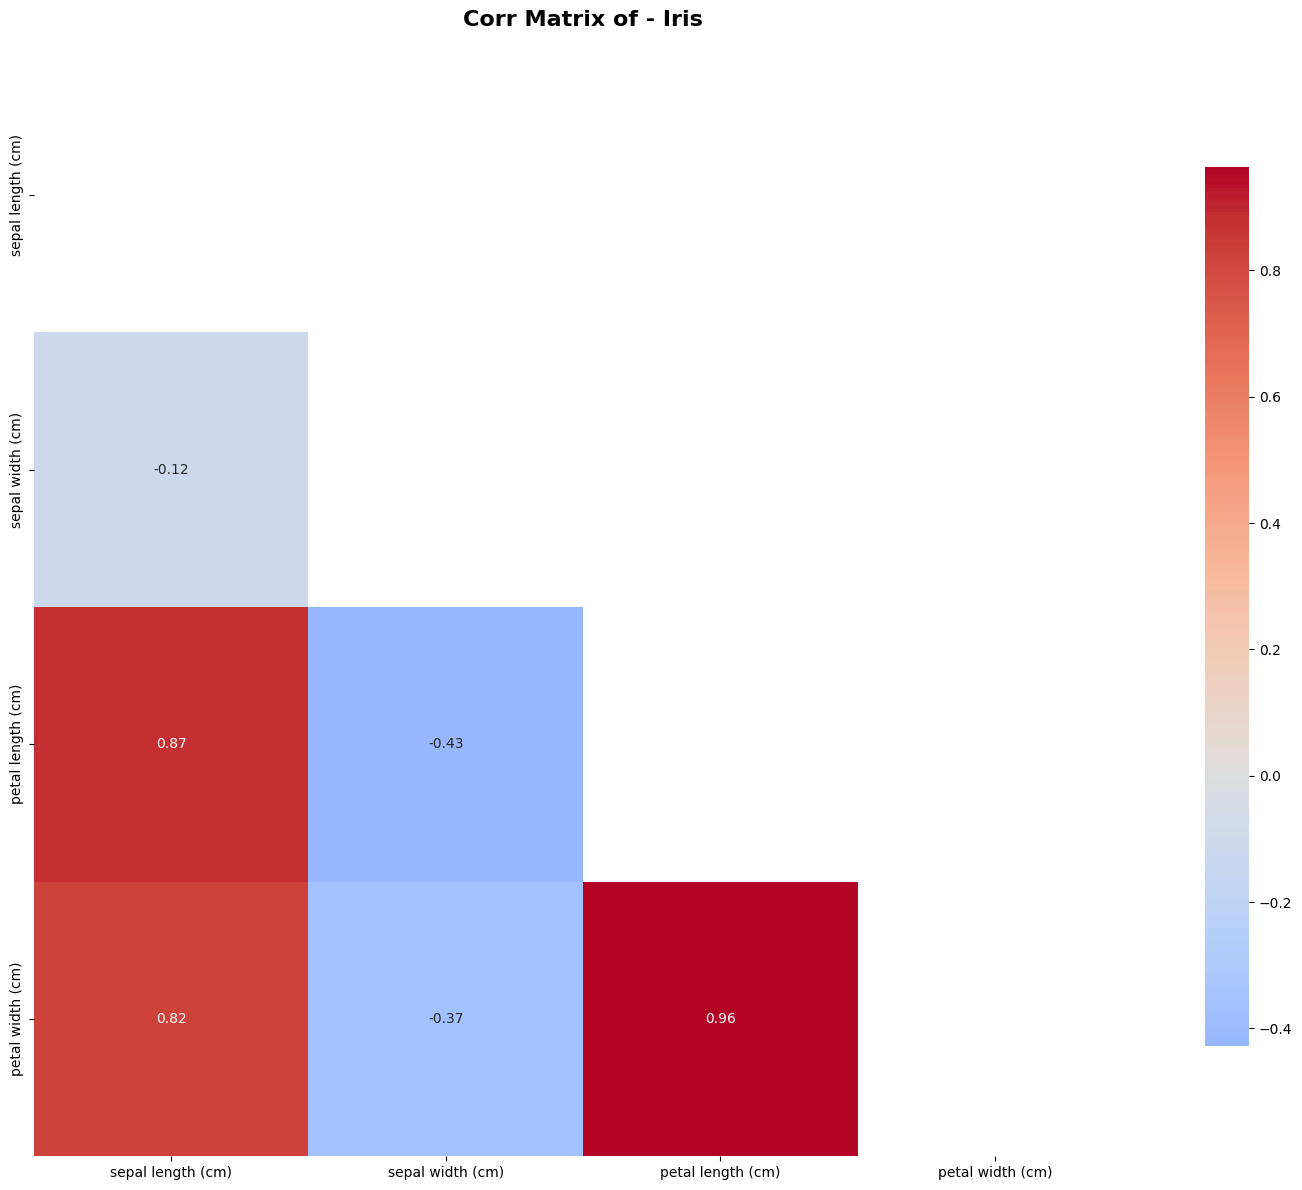

(                   sepal length (cm)  sepal width (cm)  petal length (cm)  \
 sepal length (cm)           1.000000         -0.117570           0.871754   
 sepal width (cm)           -0.117570          1.000000          -0.428440   
 petal length (cm)           0.871754         -0.428440           1.000000   
 petal width (cm)            0.817941         -0.366126           0.962865   
 
                    petal width (cm)  
 sepal length (cm)          0.817941  
 sepal width (cm)          -0.366126  
 petal length (cm)          0.962865  
 petal width (cm)           1.000000  ,
      sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
 0                  5.1               3.5                1.4               0.2
 1                  4.9               3.0                1.4               0.2
 2                  4.7               3.2                1.3               0.2
 3                  4.6               3.1                1.5               0.2
 4               

In [8]:
# calculate_correlation_matrix("Cancer", cancer_df)
# calculate_correlation_matrix("Housing", housing_df)
calculate_correlation_matrix("Iris", iris_df)

In [9]:
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler

def apply_pca(X, variance_threshold=0.95):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    pca = PCA()
    pca.fit(X_scaled)
    
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(cumulative_variance >= variance_threshold) + 1
    
    pca_final = PCA(n_components=n_components)
    X_pca = pca_final.fit_transform(X_scaled)
    
    return X_pca, n_components, cumulative_variance

def apply_ica(X, n_components=None):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    if n_components is None:
        n_components = X.shape[1]
    
    ica = FastICA(n_components=n_components, random_state=42)
    X_ica = ica.fit_transform(X_scaled)
    
    return X_ica

def apply_svd(X, n_components=None):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    if n_components is None:
        n_components = min(X_scaled.shape)
    
    U, s, Vt = np.linalg.svd(X_scaled, full_matrices=False)
    
    explained_variance = (s ** 2) / np.sum(s ** 2)
    cumulative_variance = np.cumsum(explained_variance)
    
    X_svd = U[:, :n_components] * s[:n_components]
    
    return X_svd, n_components, cumulative_variance


cancer_df_drop_tar = cancer_df.drop('target', axis=1)
cancer_df__pca, n_pca, var_pca = apply_pca(cancer_df_drop_tar)
cancer_df__ica = apply_ica(cancer_df_drop_tar, n_components=n_pca)
cancer_df__svd, n_svd, var_svd = apply_svd(cancer_df_drop_tar, n_components=n_pca)

housing_df_drop_tar = housing_df.drop('target', axis=1)
housing_df__pca, n_pca, var_pca = apply_pca(housing_df_drop_tar)
housing_df__ica = apply_ica(housing_df_drop_tar, n_components=n_pca)
housing_df__svd, n_svd, var_svd = apply_svd(housing_df_drop_tar, n_components=n_pca)

iris_df_drop_tar = iris_df.drop('target', axis=1)
iris_df__pca, n_pca, var_pca = apply_pca(iris_df_drop_tar)
iris_df__ica = apply_ica(iris_df_drop_tar, n_components=n_pca)
iris_df__svd, n_svd, var_svd = apply_svd(iris_df_drop_tar, n_components=n_pca)

In [11]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_val_score

def compare_methods(X_original, y, X_pca, X_ica, X_svd):
    scores = {}
    
    if len(np.unique(y)) <= 10:
        model = RandomForestClassifier(random_state=42)
        scoring = 'accuracy'
    else:
        model = RandomForestRegressor(random_state=42)
        scoring = 'r2'
    
    scores['Original'] = cross_val_score(model, X_original, y, cv=5, scoring=scoring).mean()
    scores['PCA'] = cross_val_score(model, X_pca, y, cv=5, scoring=scoring).mean()
    scores['ICA'] = cross_val_score(model, X_ica, y, cv=5, scoring=scoring).mean()
    scores['SVD'] = cross_val_score(model, X_svd, y, cv=5, scoring=scoring).mean()
    
    best_method = max(scores, key=scores.get)
    return best_method, scores

best_cancer, scores_cancer = compare_methods(
    cancer_df_drop_tar, cancer_df['target'], 
    cancer_df__pca, cancer_df__ica, cancer_df__svd
)

best_housing, scores_housing = compare_methods(
    housing_df_drop_tar, housing_df['target'],
    housing_df__pca, housing_df__ica, housing_df__svd
)

best_iris, scores_iris = compare_methods(
    iris_df_drop_tar, iris_df['target'],
    iris_df__pca, iris_df__ica, iris_df__svd
)

print(f"Breast Cancer - Best: {best_cancer}, Scores: {scores_cancer}")
print(f"California Housing - Best: {best_housing}, Scores: {scores_housing}")
print(f"Iris - Best: {best_iris}, Scores: {scores_iris}")

Breast Cancer - Best: Original, Scores: {'Original': np.float64(0.9560937742586555), 'PCA': np.float64(0.947259742276044), 'ICA': np.float64(0.9261605340785592), 'SVD': np.float64(0.9525073746312683)}
California Housing - Best: Original, Scores: {'Original': np.float64(0.6561187027256853), 'PCA': np.float64(0.5268604365953843), 'ICA': np.float64(0.5344552849363475), 'SVD': np.float64(0.5270556613883361)}
Iris - Best: Original, Scores: {'Original': np.float64(0.9666666666666668), 'PCA': np.float64(0.9066666666666666), 'ICA': np.float64(0.8933333333333333), 'SVD': np.float64(0.9066666666666666)}
